In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image
from PIL import ImageFont, ImageDraw
from IPython.display import display

from matplotlib import pylab as P
import os
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import saliency.core as saliency

%matplotlib inline
#GPU연결
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [2]:
box1 = pd.read_csv(r'C:\Users\OIDL_JB\Desktop\Python_Practice\Faster RCNN\ML_Project\sj\label_010.csv')
box2 = pd.read_csv(r'C:\Users\OIDL_JB\Desktop\Python_Practice\Faster RCNN\ML_Project\sj\label_020.csv')
box3 = pd.read_csv(r'C:\Users\OIDL_JB\Desktop\Python_Practice\Faster RCNN\ML_Project\sj\label_030.csv')
box4 = pd.read_csv(r'C:\Users\OIDL_JB\Desktop\Python_Practice\Faster RCNN\ML_Project\sj\label_040.csv')
box5 = pd.read_csv(r'C:\Users\OIDL_JB\Desktop\Python_Practice\Faster RCNN\ML_Project\sj\label_050.csv')
box6 = pd.read_csv(r'C:\Users\OIDL_JB\Desktop\Python_Practice\Faster RCNN\ML_Project\sj\label_060.csv')
box7 = pd.read_csv(r'C:\Users\OIDL_JB\Desktop\Python_Practice\Faster RCNN\ML_Project\sj\label_070.csv')

box2

,img_name,x1,y1,x2,y2
0,02-0000,972.514954,130.979431,1091.452515,217.287384
1,02-0000,166.640762,145.191513,243.671890,187.300491
2,02-0000,160.752930,329.940674,241.806488,500.152344
3,02-0000,307.447440,112.075521,359.790924,143.498900
4,02-0000,153.061867,219.634981,171.893374,288.087246
...,...,...,...,...,...
30254,02-0899,1144.475106,300.546366,1154.757241,337.979498
30255,02-0899,1170.250040,304.312504,1192.945451,345.647461
30256,02-0899,1246.130423,296.343036,1269.391765,339.326178
30257,02-0899,926.563537,74.475634,1090.953787,140.772119


In [3]:
class CarDataset(Dataset):
    def __init__(self, df, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = df["img_name"].unique() # all image filenames
        self.df = df
        self.image_dir = image_dir # dir to image files
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]                  
        records = self.df[self.df["img_name"] == image_id]                       
        image = LoadImage(f"{self.image_dir}\{image_id}.jpg")
                        
        boxes = records[["x1", "y1", "x2", "y2"]].values
        
        
        # class가 1종류이기 때문에 label은 1로만 지정
        labels = torch.ones((records.shape[0]), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes.astype(np.int64)
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])        


        if self.transforms:
            sample = {"image": image, "boxes": target["boxes"], "labels": labels}
            sample = self.transforms(**sample)
            image = sample["image"]
            target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["boxes"])))).permute(1, 0)

        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

dir_train = r'C:\Users\OIDL_JB\Desktop\Python_Practice\Faster RCNN\ML_Project\sj\training_images'
train1 = CarDataset(box1, dir_train)
train2 = CarDataset(box2, dir_train)
train3 = CarDataset(box3, dir_train)
train4 = CarDataset(box4, dir_train)
train5 = CarDataset(box5, dir_train)
train6 = CarDataset(box6, dir_train)
train7 = CarDataset(box7, dir_train)

In [5]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    # im = im.resize((299, 299))
    im = np.asarray(im)
    return im

transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [6]:
model = models.inception_v3(pretrained=True, init_weights=False)
eval_mode = model.eval()

# Register hooks for Grad-CAM, which uses the last convolution layer
conv_layer = model.Mixed_7c
conv_layer_outputs = {}
def conv_layer_forward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_LAYER_VALUES] = torch.movedim(o, 1, 3).detach().numpy()
def conv_layer_backward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_OUTPUT_GRADIENTS] = torch.movedim(o[0], 1, 3).detach().numpy()
conv_layer.register_forward_hook(conv_layer_forward)
conv_layer.register_full_backward_hook(conv_layer_backward)

In [7]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

In [8]:
# Load the image
im_orig, bbox, image_id = train1[100]
bbox = bbox['boxes']
im = im_orig.astype(np.float32)
print(bbox[0][0])

456


In [9]:
def Image(im_orig):
    im_tensor = PreprocessImages([im_orig])
    im = im_orig.astype(np.float32)
    return im

def SmoothGrad_and_CAM(im):
    call_model_args = {class_idx_str: 468}
    # Construct the saliency object. This alone doesn't do anthing.
    gradient_saliency = saliency.GradientSaliency()
    grad_cam = saliency.GradCam()
    # Compute the vanilla mask and the smoothed mask.
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)
    smooth_grad_cam_mask_3d = grad_cam.GetSmoothedMask(im, call_model_function, call_model_args)
    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)
    smooth_grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_grad_cam_mask_3d)
  
    return smoothgrad_mask_grayscale, smooth_grad_cam_mask_grayscale

def Energy_based_pointing(map, bbox):    
    Tot = map.sum()    
    Store = []
    for j in range(len(bbox)):
        x1 = bbox[j][0];y1 = bbox[j][1];x2 = bbox[j][2];y2 = bbox[j][3]                  
        S = 0
        for i in range(y1, y2):        
            S = sum(map[i][x1:x2])
            Store.append(S)
    return sum(Store)/Tot        
def ImageShow(im_orig, smoothgrad_mask_grayscale, smooth_grad_cam_mask_grayscale, E1, E2, num):
    # Set up matplot lib figures.
    ROWS = 3
    COLS = 1
    UPSCALE_FACTOR = 8
    P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

    # Render the saliency masks.
    ShowImage(im_orig, title='Original', ax=P.subplot(ROWS, COLS, 1))
    ShowGrayscaleImage(smoothgrad_mask_grayscale, title= f'SmoothGrad, EBP = {E1:.2f} %', ax=P.subplot(ROWS, COLS, 2))
    ShowGrayscaleImage(smooth_grad_cam_mask_grayscale, title= f'Smoothgrad Grad-CAM, EBP = {E2:.2f} %', ax=P.subplot(ROWS, COLS, 3))              
    P.savefig(f'./Result7/result{num}.png', dpi = 300)


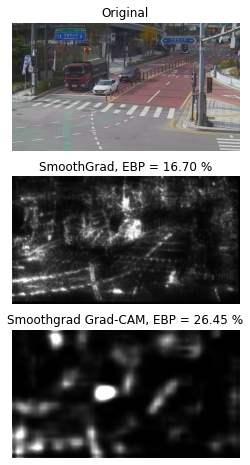

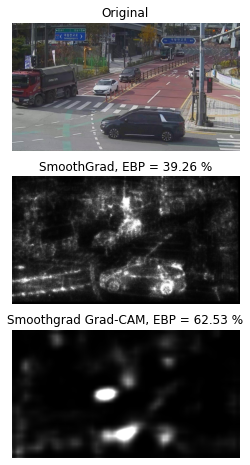

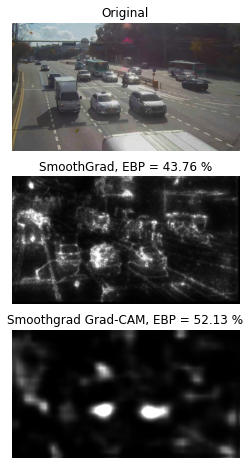

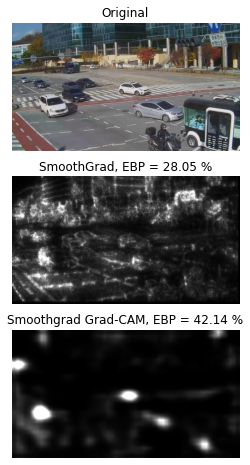

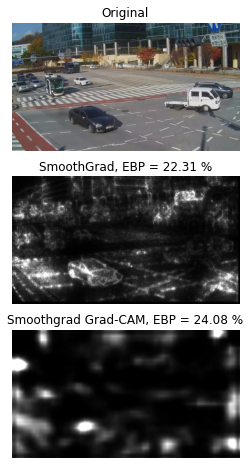

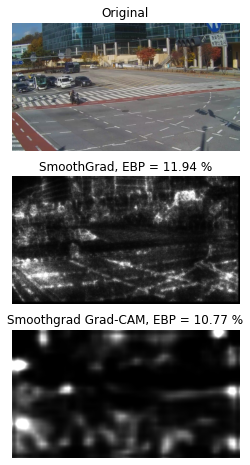

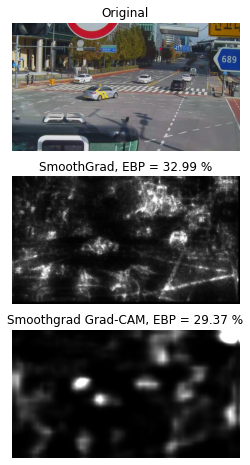

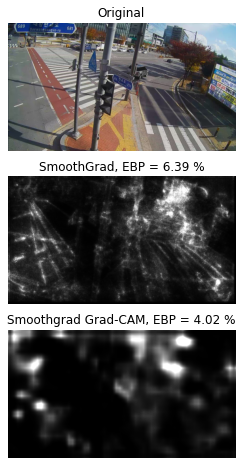

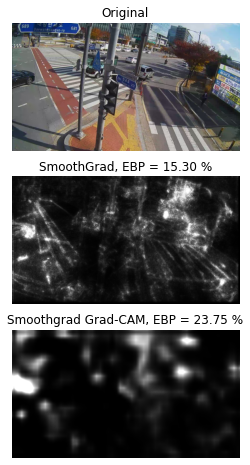

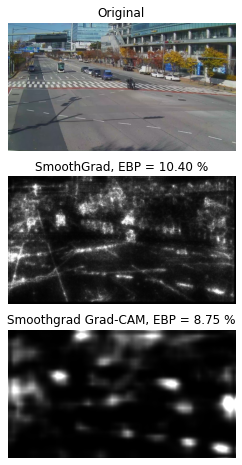

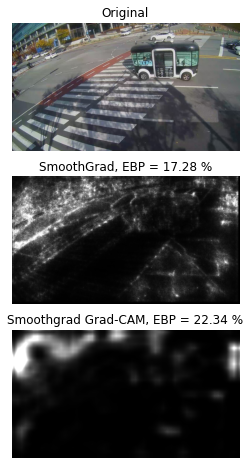

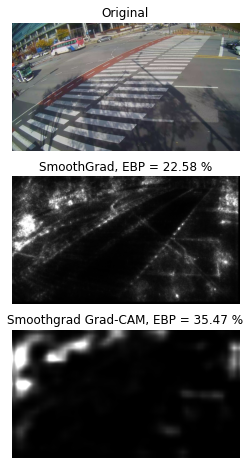

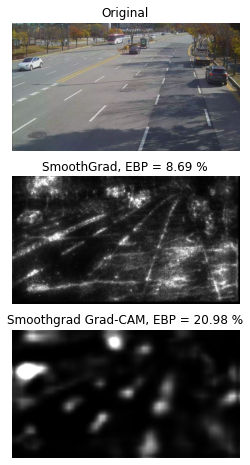

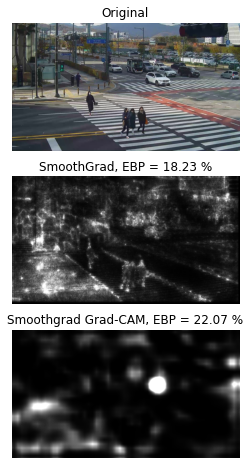

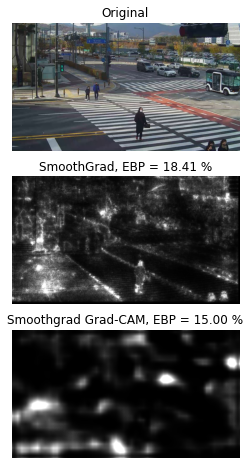

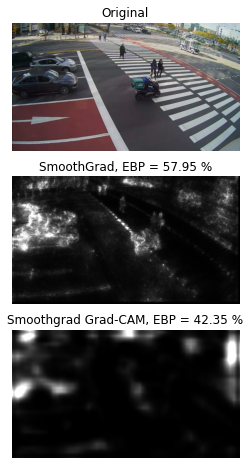

In [10]:
for i in range(0, 800, 50):
    im_orig, bbox, image_id = train7[i]
    bbox = bbox['boxes']    
    im = Image(im_orig)
    smoothgrad, grad_cam = SmoothGrad_and_CAM(im)
    E1 = Energy_based_pointing(smoothgrad, bbox)
    E2 = Energy_based_pointing(grad_cam, bbox)
    ImageShow(im_orig, smoothgrad, grad_cam, E1*100, E2*100, i)